In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from network_model import *

import sys
#!{sys.executable} -m pip install [arg]
import time

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [3]:
N = 300

In [4]:
g = nx.powerlaw_cluster_graph(n=N, m=2, p=0.5)

In [5]:
timea = time.time()
W, I, communities, delta_pos, gamma_pos, success, allocations, C, attention = simulation(NUM_AGENTS=N,
                                                                                         STEPS=50,
                                                                                         PROJECT_COST=0.01,
                                                                                         graph=g,
                                                                                         seed=123,
                                                                                         DEFAULT_A=0.3)
print(time.time()-timea)

51 communities.
Computing optimal portfolios...


/Users/charlesdupont/Desktop/poverty-trap/network_model.py:236: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C = np.array(results)


Performing time stepping...


 20%|██        | 10/50 [00:00<00:03, 12.13it/s]

Updating portfolios... (step = 10)


/Users/charlesdupont/Desktop/poverty-trap/network_model.py:236: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C = np.array(results)
 40%|████      | 20/50 [00:18<00:23,  1.29it/s]

Updating portfolios... (step = 20)


 40%|████      | 20/50 [00:30<00:23,  1.29it/s]/Users/charlesdupont/Desktop/poverty-trap/network_model.py:236: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C = np.array(results)
 60%|██████    | 30/50 [00:43<00:23,  1.15s/it]

Updating portfolios... (step = 30)


/Users/charlesdupont/Desktop/poverty-trap/network_model.py:236: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C = np.array(results)
 76%|███████▌  | 38/50 [01:00<00:15,  1.31s/it]

Updating portfolios... (step = 40)


/Users/charlesdupont/Desktop/poverty-trap/network_model.py:236: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C = np.array(results)
100%|██████████| 50/50 [01:17<00:00,  1.55s/it]

101.58792495727539


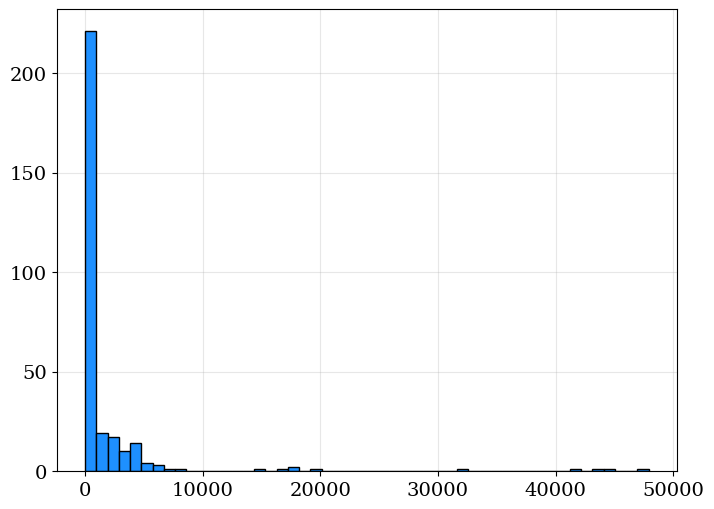

In [8]:
plt.hist(W[-1], bins=50, color="dodgerblue", edgecolor="k")
plt.show()

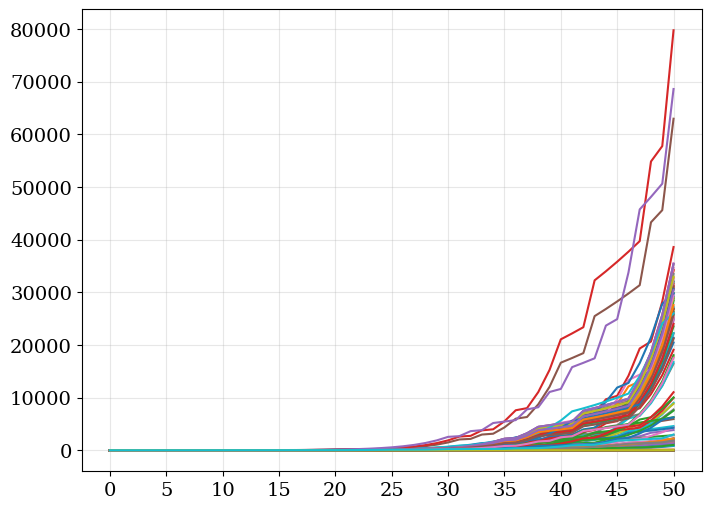

In [30]:
for i in range(W.shape[1]):
    plt.plot(W[:,i])
plt.xticks(np.arange(0, len(W), 5))
plt.show()

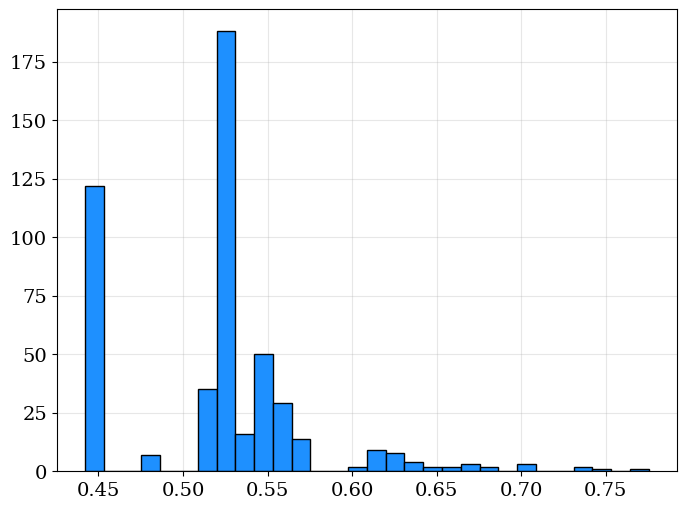

In [31]:
plt.hist(C[-1], color="dodgerblue", edgecolor="k", bins=30)
plt.show()

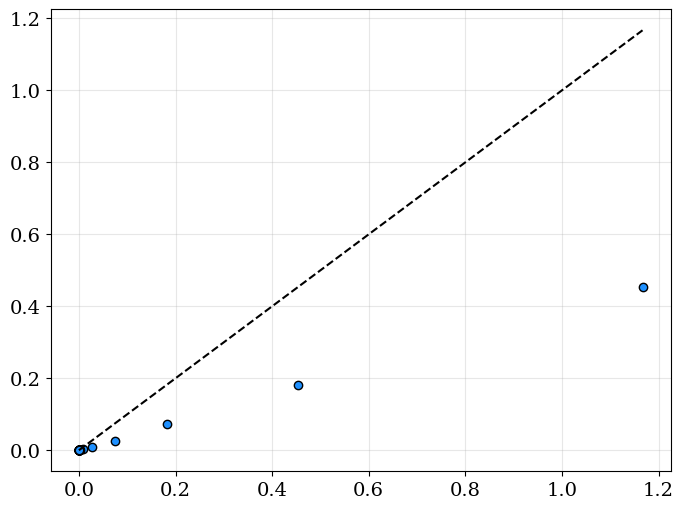

In [13]:
i = 10

x=[]
y=[]
for k in range(len(W)-1):
    x.append(W[k][i])
    y.append(W[k+1][i])

plt.scatter(x,y, color="dodgerblue", edgecolor="k")
plt.plot(np.linspace(min(x), max(x), 100), np.linspace(min(x), max(x), 100), color="k", linestyle="dashed")
plt.show()